In [115]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [116]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [117]:
hist

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2015-09-12,240.32,233.32,239.90,43773.90,1.040718e+07,235.60,direct,
2015-09-13,236.16,228.28,235.60,51595.80,1.198336e+07,230.19,direct,
2015-09-14,232.64,225.96,230.19,61097.39,1.407091e+07,229.91,direct,
2015-09-15,242.83,228.03,229.91,49516.04,1.142547e+07,229.53,direct,
2015-09-16,230.89,225.05,229.53,51913.10,1.186673e+07,228.60,direct,
...,...,...,...,...,...,...,...,...
2021-02-28,46645.90,43061.92,46191.39,62249.50,2.776726e+09,45261.03,direct,
2021-03-01,49812.20,45058.98,45261.03,65660.60,3.146266e+09,49635.07,direct,
2021-03-02,50221.14,47097.84,49635.07,43281.84,2.105388e+09,48501.21,direct,


In [118]:
hist = hist.drop(columns = ['conversionType','conversionSymbol'])

In [119]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [120]:
train, test = train_test_split(hist, test_size=0.2)

In [121]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

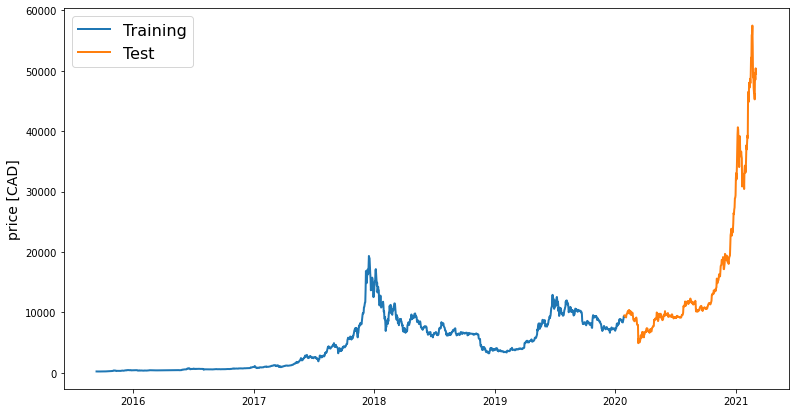

In [122]:
line_plot(train[target_col], test[target_col], 'Training', 'Test', title='')

In [123]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [124]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [125]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [126]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [127]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [128]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [129]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/100
50/50 [==============================] - 2s 6ms/step - loss: 0.0062
Epoch 2/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 3/100
50/50 [==============================] - 0s 6ms/step - loss: 0.0033
Epoch 4/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 5/100
50/50 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 6/100
50/50 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 7/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 8/100
50/50 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 9/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 10/100
50/50 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 11/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 12/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 13/100
50/50 [=================

In [130]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.028082201347969602

time
2020-02-04     9171.98
2020-02-05     9611.42
2020-02-06     9755.84
2020-02-07     9808.36
2020-02-08     9898.25
                ...   
2021-02-28    45261.03
2021-03-01    49635.07
2021-03-02    48501.21
2021-03-03    50392.55
2021-03-04    49535.36
Name: close, Length: 395, dtype: float64
Closing Price:


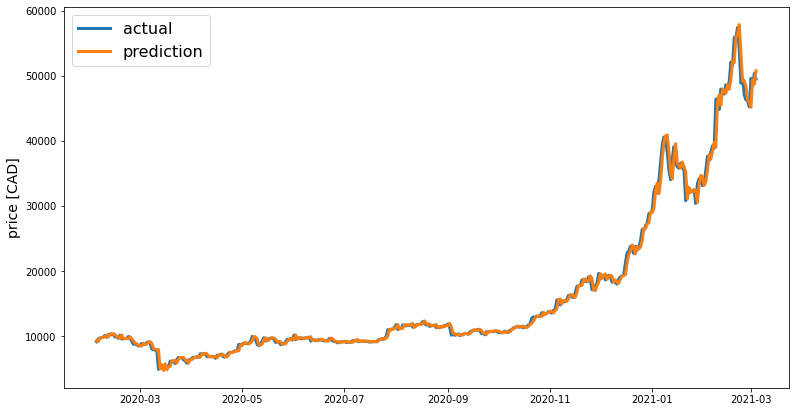

In [131]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot( targets, preds, 'actual', 'prediction', lw=3)
print(targets)
print("Closing Price:")
